### debugging the main script!

In [1]:
%load_ext autoreload

In [2]:
%autoreload

In [3]:
import argparse
from wmhuq.preprocessing import load_csvs, VPrint, load_image, get_resampled_img, normalize_brain, get_vent_dist
from wmhuq.models import load_ssn, load_model_weights
from wmhuq.inference import ssn_ensemble_mean_and_samples, entropy_map_from_samples, reorder_samples, extract_features, load_fazekas_model, load_qc_model
import SimpleITK as sitk
import torch
import pandas as pd
from wmhuq.preprocessing import OUT_SPACING
import os
import math
import matplotlib.pyplot as plt
import numpy as np

NUM_SAMPLES = 10
LOW_PERC = 5
HIGH_PERC = 95

python wmhuq/main.py -t1 0_T1.nii.gz -flair 0_FLAIR.nii.gz -mask 0_mask.nii.gz -synthseg 0_T1_synthseg.nii.gz -o . -w . --resample --zscore --verbose --fazekas --qc

In [4]:
from collections import namedtuple

In [ ]:
H = 224
W = 160

In [97]:
ARGS = namedtuple('args', 't1 flair mask synthseg o w resample zscore gpu verbose fazekas qc saveimgs device resize')

In [98]:
args = ARGS(
    # t1="../11_T1.nii.gz",
    # flair="../11_FLAIR.nii.gz",
    # mask="../11_mask.nii.gz",
    # synthseg="../11_T1_synthseg.nii.gz",
    
    # t1="../CVD283_T1.nii.gz",
    # flair="../CVD283_FLAIR.nii.gz",
    # mask="../CVD283_mask.nii.gz",
    # synthseg="../CVD283_T1_synthseg.nii.gz",
    
    t1="../ADNI_014_S_4401_20111202_T1.nii.gz",
    flair="../ADNI_014_S_4401_20111202_FLAIR.nii.gz",
    mask="../ADNI_014_S_4401_20111202_mask.nii.gz",
    synthseg="../ADNI_014_S_4401_20111202_T1_synthseg.nii.gz",
    

    
    o=".",
    w="../",
    resample=False,
    zscore=False,
    verbose=True,
    fazekas=True,
    gpu=False,
    qc=True,
    saveimgs=True,
    device='cpu',
    resize=False,
)

In [12]:
# get paths to input files
is_csv = args.t1.endswith(".csv")
input_files = args.t1, args.flair, args.mask, args.synthseg
if is_csv:
    t1s, flairs, masks, synthsegs = load_csvs(input_files)
else:
    t1s, flairs, masks, synthsegs = input_files
    t1s, flairs, masks, synthsegs = [t1s], [flairs], [masks], [synthsegs]

# verbose?
vprint = VPrint(args.verbose)

In [13]:
# load model and model weights
vprint("Loading segmentation model weights")
# args.device = "cuda" if args.gpu else "cpu"
model = load_ssn(args.device)
model = model.eval()
weight_names = [f"ssn_ens{i}_cv0" for i in range(10)]
weight_paths = [os.path.join(args.w, wn) for wn in weight_names]
for wp in weight_paths:
    if not os.path.exists(wp):
        raise ValueError("model weights not found")
config_models = [load_model_weights(model, wp) for wp in weight_paths]

Loading segmentation model weights


In [14]:
vprint("loading fazekas and qc model weights")
fazekas_model = load_fazekas_model(args.w)
qc_model = load_qc_model(args.w)

loading fazekas and qc model weights
model columns:  ['mean_t0.2_wmhsum' 'mean_t0.2_wmh_region_sums_ring3'
 'mean_t0.2_region_cc_num_ring3' 'mean_t0.2_region_cc_num_ring4'
 'mean_t0.2_region_cc_num_above_thalamus_deep'
 'mean_t0.2_mean_cc_region_sizes_ring3'
 'mean_t0.2_mean_cc_region_sizes_thalamus'
 'mean_t0.2_std_cc_region_sizes_ring2'
 'mean_t0.2_std_cc_region_sizes_ring4'
 'mean_t0.2_std_cc_region_sizes_thalamus'
 'mean_t0.2_std_cc_region_sizes_above_thalamus_deep'
 'mean_t0.2_region12_confluence' 'mean_t0.2_region23_confluence'
 'umap_raw_t0.2_wmhsum' 'umap_raw_t0.2_wmh_region_sums_ring3'
 'umap_raw_t0.2_wmh_region_sums_above_thalamus_deep'
 'umap_raw_t0.2_region_cc_num_ring4'
 'umap_raw_t0.2_std_cc_region_sizes_ring2'
 'umap_raw_t0.2_std_cc_region_sizes_ring4']
model columns:  ['mean_t0.2_wmhsum' 'mean_t0.2_wmh_region_sums_ring1'
 'mean_t0.2_wmh_region_sums_ring2' 'mean_t0.2_wmh_region_sums_thalamus'
 'mean_t0.2_wmh_region_sums_thalamus+caudate'
 'mean_t0.2_region_cc_num_ring3' 

In [15]:
# load input data
vprint("loading image data")
t1_path, flair_path, mask_path, synthseg_path = input_files
t1_image = sitk.ReadImage(t1_path)
flair_image = sitk.ReadImage(flair_path)
mask_image = sitk.ReadImage(mask_path)
synthseg_image = sitk.ReadImage(synthseg_path)
synthseg_image_orig = sitk.ReadImage(synthseg_path)
    

loading image data


In [16]:
t1_image.GetSpacing()

(1.0, 1.0, 3.0)

In [17]:
# resample
if args.resample:
    vprint("resampling")
    t1_image = get_resampled_img(t1_image, OUT_SPACING, is_label=False, verbose=args.verbose)
    flair_image = get_resampled_img(flair_image, OUT_SPACING, is_label=False, verbose=args.verbose)
    mask_image = get_resampled_img(mask_image, OUT_SPACING, is_label=True, verbose=args.verbose)
    synthseg_image = get_resampled_img(synthseg_image, OUT_SPACING, is_label=True, verbose=args.verbose)

In [18]:
device = args.device
t1 = torch.from_numpy(sitk.GetArrayFromImage(t1_image)).to(device)
flair = torch.from_numpy(sitk.GetArrayFromImage(flair_image)).to(device)
mask = torch.from_numpy(sitk.GetArrayFromImage(mask_image)).to(device)
synthseg = torch.from_numpy(sitk.GetArrayFromImage(synthseg_image)).to(device)

print("input shapes t1 flair mask synthseg")
print(t1.shape, flair.shape, mask.shape, synthseg.shape)

input shapes t1 flair mask synthseg
torch.Size([58, 220, 220]) torch.Size([58, 220, 220]) torch.Size([58, 220, 220]) torch.Size([58, 220, 220])


(-0.5, 219.5, -0.5, 219.5)

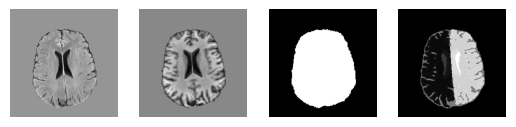

In [21]:
islice=37
plt.subplot(1,4,1)
plt.imshow(flair[islice], cmap='gray', origin='lower')
plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(t1[islice], cmap='gray', origin='lower')
plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(mask[islice], cmap='gray', origin='lower')
plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(synthseg[islice], cmap='gray', origin='lower')
plt.axis('off')

In [22]:
if args.zscore:
    vprint("z-score normalizing")
    t1 = normalize_brain(t1, mask, lower_percentile=LOW_PERC, upper_percentile=HIGH_PERC)
    flair = normalize_brain(flair, mask, lower_percentile=LOW_PERC, upper_percentile=HIGH_PERC)

(-0.5, 219.5, -0.5, 219.5)

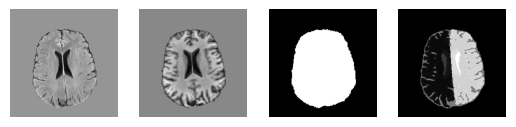

In [23]:
plt.subplot(1,4,1)
plt.imshow(flair[islice], cmap='gray', origin='lower')
plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(t1[islice], cmap='gray', origin='lower')
plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(mask[islice], cmap='gray', origin='lower')
plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(synthseg[islice], cmap='gray', origin='lower')
plt.axis('off')

In [24]:
if args.resize:
    vprint("cropping")
    flair = flair[:, 3:-3, 35:-35]
    t1 = t1[:, 3:-3, 35:-35]
    mask = mask[:, 3:-3, 35:-35]
    synthseg = synthseg[:, 3:-3, 35:-35]

In [51]:
vprint("running segmentation model")
x = torch.stack([flair, t1, mask])
mean, samples = ssn_ensemble_mean_and_samples(config_models, x, NUM_SAMPLES, device)
umap = entropy_map_from_samples(samples, normalize=True) / -math.log(0.5)
p_hat = torch.nn.functional.softmax(mean, dim=1)[:, 1]
samples = reorder_samples(samples)
samples = torch.nn.functional.softmax(samples, dim=2)[:,:,1]

running segmentation model


/home/s2208943/miniconda3/envs/wmhuq/lib/python3.10/site-packages/torch/nn/modules/instancenorm.py:88: UserWarning: input's size at dim=1 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(f"input's size at dim={feature_dim} does not match num_features. "


In [52]:
print("SIZES")
print("samples: ", samples.shape)
print("mean: ", mean.shape)
print("umap: ", umap.shape)

SIZES
samples:  torch.Size([10, 58, 220, 220])
mean:  torch.Size([58, 2, 220, 220])
umap:  torch.Size([58, 220, 220])


In [63]:
# %autoreload

In [54]:
# calculate ventricle distance map
vent_dist = get_vent_dist(synthseg_image_orig, args.verbose)
vent_dist = torch.from_numpy(vent_dist).to(device)

if args.resize:
    vent_dist = vent_dist[:, 3:-3, 35:-35]

print("vent dist: ", vent_dist.shape)

original spacing:  [1.0, 1.0, 3.0]
original spacing:  (1.0, 1.0, 1.0)
vent dist:  torch.Size([58, 220, 220])


(-0.5, 219.5, -0.5, 219.5)

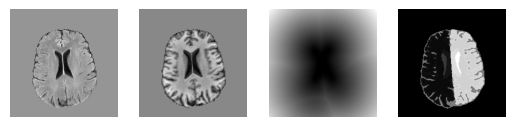

In [55]:
plt.subplot(1,4,1)
plt.imshow(flair[islice], cmap='gray', origin='lower')
plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(t1[islice], cmap='gray', origin='lower')
plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(vent_dist[islice], cmap='gray', origin='lower')
plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(synthseg[islice], cmap='gray', origin='lower')
plt.axis('off')

(-0.5, 219.5, -0.5, 219.5)

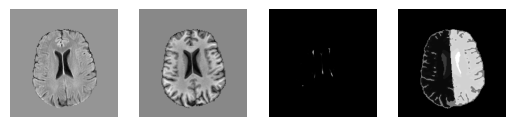

In [56]:
plt.subplot(1,4,1)
plt.imshow(flair[islice], cmap='gray', origin='lower')
plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(t1[islice], cmap='gray', origin='lower')
plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(p_hat[islice], cmap='gray', origin='lower')
plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(synthseg[islice], cmap='gray', origin='lower')
plt.axis('off')

(-0.5, 219.5, -0.5, 219.5)

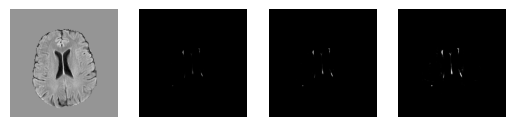

In [57]:
plt.subplot(1,4,1)
plt.imshow(flair[islice], cmap='gray', origin='lower')
plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(samples[0,islice], cmap='gray', origin='lower')
plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(samples[5,islice], cmap='gray', origin='lower')
plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(samples[9,islice], cmap='gray', origin='lower')
plt.axis('off')

In [64]:
output_feats = extract_features(synthseg, vent_dist, samples, p_hat, umap)

updated version



KNOWN COLUMNS
Index(['sample_0_t0.1_wmhsum', 'sample_0_t0.1_wmh_region_sums_ring1',
       'sample_0_t0.1_wmh_region_sums_ring2',
       'sample_0_t0.1_wmh_region_sums_ring3',
       'sample_0_t0.1_wmh_region_sums_ring4',
       'sample_0_t0.1_wmh_region_sums_thalamus',
       'sample_0_t0.1_wmh_region_sums_thalamus+caudate',
       'sample_0_t0.1_wmh_region_sums_above_thalamus_pv',
       'sample_0_t0.1_wmh_region_sums_above_thalamus_deep',
       'sample_0_t0.1_region_cc_num_ring1',
       ...
       'umap_atseg_t0.2_std_cc_region_sizes_ring1',
       'umap_atseg_t0.2_std_cc_region_sizes_ring2',
       'umap_atseg_t0.2_std_cc_region_sizes_ring3',
       'umap_atseg_t0.2_std_cc_region_sizes_ring4',
       'umap_atseg_t0.2_std_cc_region_sizes_thalamus',
       'umap_atseg_t0.2_std_cc_region_sizes_thalamus+caudate',
       'umap_atseg_t0.2_std_cc_region_sizes_above_thalamus_pv',
       'umap_atseg_t0.2_std_cc_region_sizes_above_thalamus_deep',
       'umap_atseg_t0.2_

In [65]:
np.sum(output_feats.values)

63688.683236289304

In [68]:
# run fazekas model
vprint("predicting fazekas and seg. quality")
fazekas_prediction = fazekas_model(output_feats)

# run qc model
qc_prediction = qc_model(output_feats)

predicting fazekas and seg. quality
#########
X that is called for prediction:
   sample_0_t0.1_wmhsum  sample_0_t0.1_wmh_region_sums_ring1   
0            186.465363                           151.160126  \

   sample_0_t0.1_wmh_region_sums_ring2  sample_0_t0.1_wmh_region_sums_ring3   
0                             4.069122                             0.265185  \

   sample_0_t0.1_wmh_region_sums_ring4   
0                            30.970919  \

   sample_0_t0.1_wmh_region_sums_thalamus   
0                               32.671745  \

   sample_0_t0.1_wmh_region_sums_thalamus+caudate   
0                                       32.671745  \

   sample_0_t0.1_wmh_region_sums_above_thalamus_pv   
0                                              0.0  \

   sample_0_t0.1_wmh_region_sums_above_thalamus_deep   
0                                          31.221493  \

   sample_0_t0.1_region_cc_num_ring1  ...   
0                                 28  ...  \

   vd_std_t0.2_std_cc_region_sizes_ab

/home/s2208943/miniconda3/envs/wmhuq/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/s2208943/miniconda3/envs/wmhuq/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/s2208943/miniconda3/envs/wmhuq/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [69]:
fazekas_model.pvwmh_model

Pipeline(steps=[('colfilter',
                 <wmhuq.inference.logreg_models.ColumnFilter object at 0x7f8d92ea7e50>),
                ('norm',
                 CustomNormalizer(log_features=array(['vd_std_t0.2_wmhsum', 'vd_std_t0.2_wmh_region_sums_ring1',
       'vd_std_t0.2_wmh_region_sums_ring2',
       'vd_std_t0.2_wmh_region_sums_ring3',
       'vd_std_t0.2_wmh_region_sums_thalamus',
       'vd_std_t0.2_wmh_region_sums_thalamus+ca...
       'vd_std_t0.2_std_cc_region_sizes_ring1',
       'vd_std_t0.2_std_cc_region_sizes_ring2',
       'vd_std_t0.2_std_cc_region_sizes_ring3',
       'vd_std_t0.2_std_cc_region_sizes_thalamus',
       'vd_std_t0.2_std_cc_region_sizes_thalamus+caudate',
       'vd_std_t0.2_std_cc_region_sizes_above_thalamus_pv',
       'vd_std_t0.2_region12_confluence',
       'vd_std_t0.2_region23_confluence'], dtype='<U50'))),
                ('clf', LogisticRegression())])

In [70]:
# this is for the adni example (should be low fazekas I think...?)
print(fazekas_prediction)
print("---------")
print(qc_prediction)

{'DWMH_0': 0.7723576354677046, 'DWMH_1': 0.2137448026916301, 'DWMH_2': 0.01324032565843548, 'DWMH_3': 0.0006572361822299121, 'PVWMH_0': 0.8861217485491417, 'PVWMH_1': 0.11199154315776823, 'PVWMH_2': 0.0018142584869191994, 'PVWMH_3': 7.244980617078204e-05}
---------
{'QC_Score': 0.05724444352397717}


In [ ]:
# this was for the cvd example (should be high fazekas I think...)
print(fazekas_prediction)
print("---------")
print(qc_prediction)

#### need to do testing now on image size vs fazekas prediction outcome, but otherwise we are good!

In [29]:
fazekas_model.dwmh_model['clf'].coef_

array([[-0.25390027, -0.15422552, -0.77473675, -0.32484415, -0.58125174,
        -0.29208382, -0.09519352, -0.14945791, -0.00784931, -0.27849556,
        -0.29722231, -0.22487249, -0.1617627 , -0.13618881, -0.09397133,
         0.12835078,  0.0057924 , -0.04129634,  0.34060439],
       [-0.17155527, -0.20449471, -0.11811303, -0.24475873,  0.13166075,
        -0.07878445, -0.13293966, -0.12434741, -0.14351424,  0.19015085,
        -0.10493074, -0.08648535, -0.12066732,  0.04662005,  0.04001912,
         0.18661373, -0.11916844,  0.04668514, -0.18587454],
       [ 0.07431128,  0.06928691,  0.53481759,  0.4001188 ,  0.44728982,
         0.25882257, -0.13026687,  0.39230369, -0.14862559,  0.28846274,
         0.15676621,  0.02385818, -0.00391614, -0.16010981, -0.18558656,
        -0.22807867, -0.21953699,  0.24856865, -0.19350409],
       [ 0.35114425,  0.28943332,  0.35803219,  0.16948408,  0.00230116,
         0.1120457 ,  0.35840005, -0.11849837,  0.29998914, -0.20011803,
         0.245

In [138]:
output_feats['mean_t0.2_wmhsum']

0    486.455688
Name: mean_t0.2_wmhsum, dtype: float64

### okay, so at this point, the pvwmh is close, but the deep is not so close
- [ ] issue. So the dwmh prediction is very different, but the pvwmh prediction is similar. Do we understand why?
- [x] check if the output segmentations are the same
- [x] is the variability higher if I restart the model entirely?
- [ ] check if we need to apply a random seed to the model to get exact answers!!!! (in this case, a seed that provides close answers to the original means the features roughly align, this is a sensible bet I suppose....)
- [x] copy across data that is preprocessed for comparison.
- [ ] copy along the non-preprocessed data for comparison.
- [ ] check if the mean features are consistent, since these should be deterministic I think!!!!
- [x] does running with more samples to compute the uncertainty map improve the determinism of the model?
- [x] check if the umap normalization is necessary or not
- [x] does croppping change the model outputs in a noticable way (i.e a clear change in the distribution of the outputs?)
- [ ] check if not doing resampling and zscore changes the result for this already preprocessed image!!!!
- [x] check how consistent the model answers are between different runs of the same model
- [ ] check if the collected features are the same
- [x] restart kernel, try no resample, no z-score, and add the cropping and see what happens.
- [x] run the model on a very high and very low fazekas score example to check that we get reasonable results.
- [ ] run on an example from the CVD dataset taking the image from the raw data vs the preprocessed data to see what happens / how things change.

Things we have found out:

- so far, the dwmh prediction is different but the pvwmh prediction is close.
- I don't appear to set a seed in the original source code, so I do not think the eval code is deterministic here.
- no it is not deterministic but the variability is not that large.
- restarting the kernel doesn't lead to bigger model output differences.
- the original segmentation that we have looks more reasonable, and the mean outputs are definately not the same
- for consistency we should crop to a fixed size then, but what size? 230x230 since it seems to work well or 224 * 160.... hmm.
- we are getting nan values which I think is due to there be no wmh above a certain point. so these features should be set to zero and any remaining nans after that fact should be set to zero.

### comparing the output maps to the originals from the first run of the model

In [33]:
orig_maps = np.load("../training_Utrecht_11_out_maps.npz", allow_pickle=True)
orig_samples = np.load("../training_Utrecht_11_model_WMH_samples.npz", allow_pickle=True)

In [34]:
orig_pred = orig_maps['pred']

In [35]:
orig_pred.shape, p_hat[:, 3:-3, 35:-35].shape

((48, 224, 160), torch.Size([48, 218, 90]))

(-0.5, 159.5, -0.5, 223.5)

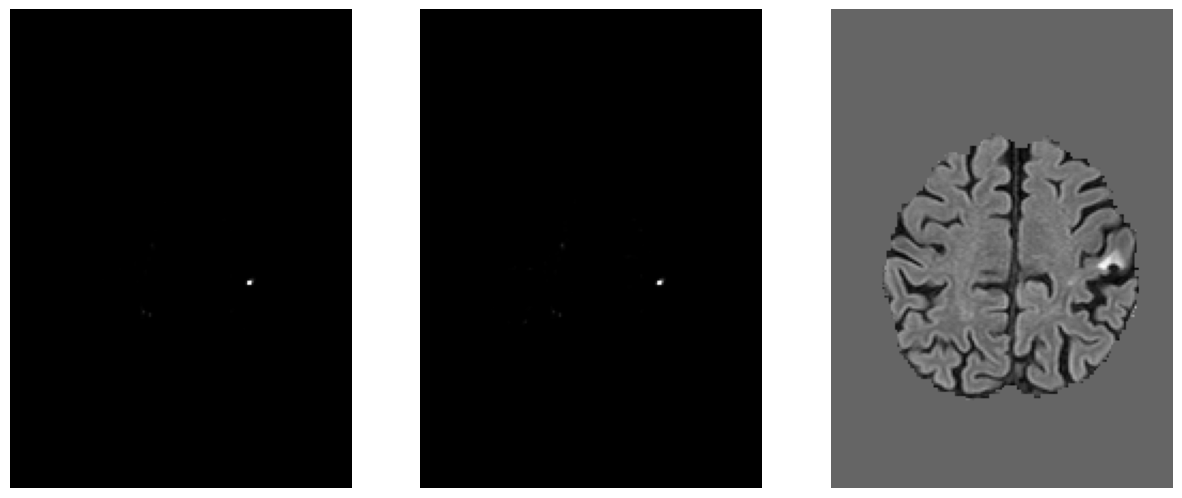

In [43]:
plt.figure(figsize=(15, 15))
islice = 37
plt.subplot(1,3,1)
plt.imshow(orig_pred[islice], origin='lower', cmap='gray')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(p_hat[islice], origin='lower', cmap='gray')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(flair[islice], origin='lower', cmap='gray')
plt.axis('off')

(-0.5, 159.5, -0.5, 223.5)

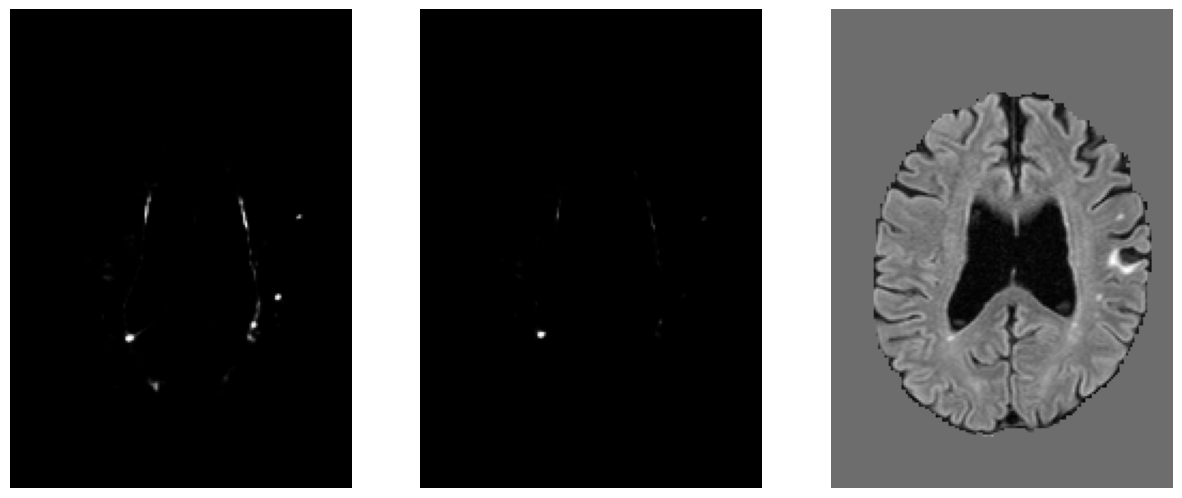

In [52]:
plt.figure(figsize=(15, 15))
islice = 30
plt.subplot(1,3,1)
plt.imshow(orig_pred[islice], origin='lower', cmap='gray')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(p_hat[islice, 3:-3, 35:-35], origin='lower', cmap='gray')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(flair[islice, 3:-3, 35:-35], origin='lower', cmap='gray')
plt.axis('off')

In [ ]:
# problem, the original segmentation is more reasonable.

In [71]:
orig_maps_cvd = np.load("../CVD283_out_maps.npz", allow_pickle=True)
orig_samples_cvd = np.load("../CVD283_model_WMH_samples.npz", allow_pickle=True)

In [74]:
orig_maps_cvd['seg'].shape # so maybe we should crop to 224 160 to be within distribution? Hmm I do not know for sure. we shall see.

(56, 224, 160)

In [78]:
%autoreload

In [79]:
import torch
from wmhuq.preprocessing import crop_or_pad

In [80]:
arr = torch.randn(48, 170, 224)

In [81]:
arr.shape

torch.Size([48, 170, 224])

In [86]:
flair.shape

torch.Size([58, 220, 220])